# Evaluation for Civirank
This is the notebook accompanying the Evaluation section of "TODO input title" where the ranker CiviRank is evaluated based on the Comment Data from the "DerStandard" comment sections from May 2019, kindly provided by Emma Fraxanet, see [here](https://academic.oup.com/pnasnexus/article/3/12/pgae276/7713083?login=false).

In [27]:
%load_ext autoreload
%autoreload 2
%pip install ipywidgets --upgrade
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension install --py widgetsnbextension --sys-prefix
from evaluation import EvaluationDataGenerator, EvaluationCollector
import pandas as pd
from civirank import CiviRank
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import parallel_coordinates
import os
from dotenv import load_dotenv
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


## Set Constants for Evaluation

In this section, we define the constants that determine the number of items to be evaluated in the analysis. This helps in maintaining consistency and reproducibility in our experiments.

- `ARTICLES_TO_EVALUATE`: The number of articles to be sampled and evaluated. Currently set to 10.
- `ARTICLES_TO_OVERVIEW`: The number of articles considered in overview diagrams.
- `AVERAGE_COMMENTS_VIEWED_ESTIMATE`: The number of comments we estimate one user to view on average, where we analyze toxicity and civility in detail.
- `CIVIRANK_SCROLL_WARNING_LIMIT`: = 0.` The threshold below wich CiviRank puts a scroll warning.

In [28]:
ARTICLES_TO_EVALUATE = 5
ARTICLES_TO_OVERVIEW = 5
AVERAGE_COMMENTS_VIEWED_ESTIMATE = 3
CIVIRANK_SCROLL_WARNING_LIMIT = -0.16 #similar to default setting
EXTERNAL_EVAL = True
EVAL_BIN_SIZE = 10
PRINT_PLOTS = True
FIGURE_PATH = "figures/"
TEMP_PATH = "temp/"
utils.FIGURE_PATH = FIGURE_PATH
rc = {
  "scatter.edgecolors": "none",
    # "font.size": 16,
    # "axes.titlesize": 18,
    # "axes.labelsize": 16,
    # "xtick.labelsize": 14,
    # "ytick.labelsize": 14,
    # "legend.fontsize": 14,
    }
#sns.set_context('paper', rc=rc) if PRINT_PLOTS else sns.set_context('notebook', rc=rc)
sns.set_theme('paper' if PRINT_PLOTS else 'notebook', 'white', rc=rc)
custom_palette = sns.color_palette("Set2", 8)
sns.set_palette(custom_palette)

## Data Import and Ranker Init
Here the Helper Class for Generating Data is initialized, it reads the data from the raw files and later provides util functions. Additionally the CiviRank ranker object is started.

In [29]:
load_dotenv()

path_to_data = "data/may_2019"
eval_gen = EvaluationDataGenerator(path_to_data)
ranker = CiviRank(language="ger", scroll_warning_limit=CIVIRANK_SCROLL_WARNING_LIMIT)

Language set to ger
ToxicityAnalyzer set to celadon


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Prosociality and Polarization Analyzers initialized
Civirank initialized!


### Comment Metadata
This imports the metadata for all comments on all articles in the Dataset, which includes all of May 2019.

In [30]:
metadata = eval_gen.get_comments_metadata()
print(f"Total amount of comments in Dataset: {len(metadata)}")

Total amount of comments in Dataset: 737903


## General Overview
First, the summed comments are analyzed in the context of the articles.
Most importantly, the median of comments on a article is calculated, as these are used in the thesis as examplary for "standard" cases of comment sections.
Other than that, the relation between total comments, total votes, up- and downvotes is explored and visualized

In [31]:
# Aggregate the sum of Votes_Pos and Votes_Neg for each Article_Id
aggregated = metadata.groupby('Article_Id').agg(
    counts=('Article_Id', 'size'),
    Votes_Pos_Sum=('Votes_Pos', 'sum'),
    Votes_Neg_Sum=('Votes_Neg', 'sum')
).reset_index()
print(f"Total amount of articles in Dataset: {len(aggregated)}")
aggregated["Votes_Total"] = aggregated["Votes_Neg_Sum"] + aggregated["Votes_Pos_Sum"]
aggregated["VotesToComments"] = aggregated["Votes_Total"] / aggregated["counts"]
aggregated["NegVotesToComments"] = aggregated["Votes_Neg_Sum"] / aggregated["counts"]
aggregated["PosffVotesToComments"] = aggregated["Votes_Pos_Sum"] / aggregated["counts"]
aggregated["NegVotesPercentage"] = (aggregated["Votes_Neg_Sum"] / aggregated["Votes_Total"]) * 100
aggregated["PosVotesPercentage"] = (aggregated["Votes_Pos_Sum"] / aggregated["Votes_Total"]) * 100
#print median, average, qantiles and max of the comment counts
print("The median of the comment counts is: ", aggregated["counts"].median())
print("The average of the comment counts is: ", aggregated["counts"].mean())
print("The 25% quantile of the comment counts is: ", aggregated["counts"].quantile(0.25))
print("The 75% quantile of the comment counts is: ", aggregated["counts"].quantile(0.75))
print("The maximum of the comment counts is: ", aggregated["counts"].max())
# get 10 articles counts closest to the median
aggregated["diff"] = abs(aggregated['counts'] - aggregated['counts'].median())

Total amount of articles in Dataset: 4499
The median of the comment counts is:  37.0
The average of the comment counts is:  164.0148921982663
The 25% quantile of the comment counts is:  10.0
The 75% quantile of the comment counts is:  138.0
The maximum of the comment counts is:  19973


## Extract Data under consideration of the Data Distribution
As the distribution of the comments is somewhat lognormal, we partition the dataset into bins of 0-10, 10-100, 100-1000 comments to account for all types of comment sections


In [32]:
# Try to load the variable
try:
  complete = pd.read_pickle(TEMP_PATH + "complete.pkl")
  overview = pd.read_pickle(TEMP_PATH + "overview.pkl")

  scores_log_bin_0 = pd.read_pickle(TEMP_PATH + "scores_log_bin_0.pkl")
  scores_log_bin_1 = pd.read_pickle(TEMP_PATH + "scores_log_bin_1.pkl")
  scores_log_bin_2 = pd.read_pickle(TEMP_PATH + "scores_log_bin_2.pkl")
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]

  sample_log_bin_0 = pd.read_pickle(TEMP_PATH + "sample_log_bin_0.pkl")
  sample_log_bin_1 = pd.read_pickle(TEMP_PATH + "sample_log_bin_1.pkl")
  sample_log_bin_2 = pd.read_pickle(TEMP_PATH + "sample_log_bin_2.pkl")
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]

  overview_log_bin_0 = pd.read_pickle(TEMP_PATH + "overview_log_bin_0.pkl")
  overview_log_bin_1 = pd.read_pickle(TEMP_PATH + "overview_log_bin_1.pkl")
  overview_log_bin_2 = pd.read_pickle(TEMP_PATH + "overview_log_bin_2.pkl")
  overviews = [overview_log_bin_0, overview_log_bin_1, overview_log_bin_2]

except FileNotFoundError:

  # parttion into logarithmic bins
  log_bin_0 = aggregated[aggregated['counts'] < 10]
  log_bin_1 = aggregated[(aggregated['counts'] >= 10) & (aggregated['counts'] < 100)]
  log_bin_2 = aggregated[(aggregated['counts'] >= 100) & (aggregated['counts'] < 1000)]

  sample_log_bin_0 = log_bin_0.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_1 = log_bin_1.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bin_2 = log_bin_2.sample(n=EVAL_BIN_SIZE, random_state=42)
  sample_log_bins = [sample_log_bin_0, sample_log_bin_1, sample_log_bin_2]
  scores_log_bin_0 = []
  scores_log_bin_1 = []
  scores_log_bin_2 = []
  scores_log_bins = [scores_log_bin_0, scores_log_bin_1, scores_log_bin_2]
  overviews = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]

  for i, bin in enumerate(sample_log_bins):
      for _, sample in bin.iterrows():
        article_id = sample["Article_Id"]
        comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
        scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
        scores_log_bins[i].append(scores)
        comments = len(comments_matched_to_metadata)
        warnings = scores["Warning"].eq("Warning").sum()
        average_civiscore = scores["CiviScore"].mean()
        average_civiscore_without_warnings = scores[scores["Warning"].ne("Warning")]["CiviScore"].mean()
        new_row = pd.DataFrame({
            "article_id": [article_id],
            "comments": [comments],
            "warnings": [warnings],
            "average_civiscore": [average_civiscore],
            "warning_proportion": [warnings / comments],
            "average_civiscore_without_warnings": [average_civiscore_without_warnings],
        })
        overviews[i] = pd.concat([overviews[i], new_row], ignore_index=True)
  complete = pd.DataFrame()
  overview = pd.DataFrame()
  for i, bin in enumerate(scores_log_bins):
    overview = pd.concat([overview, overviews[i]], ignore_index=True)
    for scores in bin:
      complete = pd.concat([complete, scores], ignore_index=True)
      
  complete.to_pickle(TEMP_PATH + "complete.pkl")
  overview.to_pickle(TEMP_PATH + "overview.pkl")

  pd.to_pickle(scores_log_bins[0], TEMP_PATH + "scores_log_bin_0.pkl")
  pd.to_pickle(scores_log_bins[1], TEMP_PATH + "scores_log_bin_1.pkl")
  pd.to_pickle(scores_log_bins[2], TEMP_PATH + "scores_log_bin_2.pkl")

  pd.to_pickle(sample_log_bins[0], TEMP_PATH + "sample_log_bin_0.pkl")
  pd.to_pickle(sample_log_bins[1], TEMP_PATH + "sample_log_bin_1.pkl")
  pd.to_pickle(sample_log_bins[2], TEMP_PATH + "sample_log_bin_2.pkl")

  pd.to_pickle(overviews[0], TEMP_PATH + "overview_log_bin_0.pkl")
  pd.to_pickle(overviews[1], TEMP_PATH + "overview_log_bin_1.pkl")
  pd.to_pickle(overviews[2], TEMP_PATH + "overview_log_bin_2.pkl")


## Visualizing typical cases
For visualizing typical cases we first examine a range of articles pseudorandomly sampled between the 40th and the 60th quantile of comment counts, to get an impression of the typical case.

In [33]:
#randomly sample ARTICLES_TO_OVERVIEW articles from the iqr
iqr = aggregated[(aggregated['counts'] >= aggregated['counts'].quantile(0.4)) & (aggregated['counts'] <= aggregated['counts'].quantile(0.6))]
articles_to_evaluate = iqr.sample(n=ARTICLES_TO_OVERVIEW, random_state=1)

nice seeds: 45 1
very nice: none
semi nice 52

In [34]:
results = []
overview_typical = pd.DataFrame()

for i, row in articles_to_evaluate.iterrows():
    article_id = row["Article_Id"]
    comments, comments_matched_to_metadata = eval_gen.extract_comments_with_metadata(article_id)
    scores = eval_gen.calculate_all_scores(comments_matched_to_metadata, comments, ranker)
    results.append(scores)
    new_row = pd.DataFrame({
        "article_id": [article_id],
        "comments": [len(comments_matched_to_metadata)],
        "warning": [scores["Warning"].eq("Warning").sum()],
        "average_civiscore": [scores["CiviScore"].mean()],
    })
    overview_typical = pd.concat([overview_typical, new_row], ignore_index=True)
overview_typical["warning_proportion"] = (overview_typical["warning"] / overview_typical["comments"])

KeyboardInterrupt: 

### Plot distribution of Civiscores

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Median in CiviScores:  0.13153828893389022
Mean in CiviScores:  0.10982665456446339


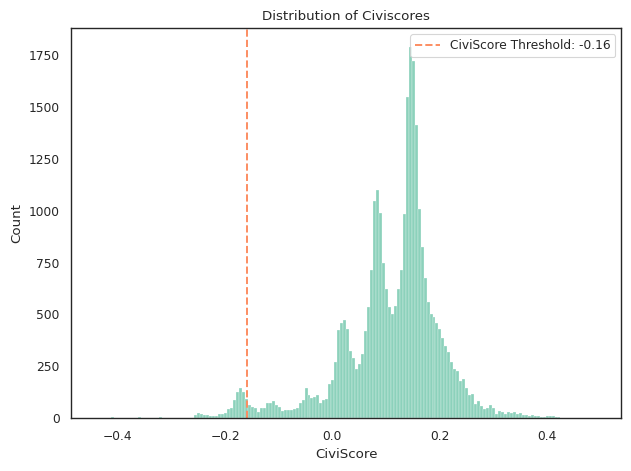

Comments ranked:  31276


In [ ]:
g = sns.histplot(data=complete['CiviScore'])
plt.axvline(-0.16, color=custom_palette[1], linestyle='--', label=f'CiviScore Threshold: -0.16', linewidth=1.4)
print("Median in CiviScores: ", complete['CiviScore'].median())
print("Mean in CiviScores: ", complete['CiviScore'].mean())

plt.legend()
plt.title("Distribution of Civiscores")
utils.plot(PRINT_PLOTS, "civiscores_distribution", plt)
print("Comments ranked: ", len(complete))


In [ ]:
import spacy
from lexicalrichness import LexicalRichness
nlp = spacy.load("de_core_news_md")
    
def preprocess(text_series, nlp):
    text_series.copy()
    cleaned_text = text_series.replace(
        to_replace=[r"(?:https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,})"],
        value=[""],
        regex=True,
    )
    cleaned_text = cleaned_text.replace(to_replace=r"&.*;", value="", regex=True)
    cleaned_text = cleaned_text.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True)
    cleaned_text = cleaned_text.replace(to_replace=r"\s+", value=" ", regex=True)
    cleaned_text = cleaned_text.replace(to_replace=r"\@\w+", value="@user", regex=True)
    cleaned_text = cleaned_text.apply(lambda x: [token.lemma_ for token in nlp(x)])
    return cleaned_text

def calculate_mtld(text_series):
    lexical_richness = LexicalRichness(text_series, preprocessor=None, tokenizer=None)
    
    try:
        mtld_value = lexical_richness.mtld()
    except ZeroDivisionError:
        mtld_value = None

    return mtld_value

try:
    mtld_complete = pd.read_pickle(TEMP_PATH + "mtld_complete.pkl")
except FileNotFoundError:
    text_to_mtld = preprocess(complete["text"], nlp)
    text_to_mtld = text_to_mtld.apply(lambda x: calculate_mtld(x))
    pd.to_pickle(text_to_mtld, TEMP_PATH + "mtld_complete.pkl")
    
print("The average MTLD is: ", text_to_mtld.mean())
print("The median MTLD is: ", text_to_mtld.median())
print("The 25% quantile of the MTLD is: ", text_to_mtld.quantile(0.25))
print("The 75% quantile of the MTLD is: ", text_to_mtld.quantile(0.75))
print("The maximum of the MTLD is: ", text_to_mtld.max())


The average MTLD is:  34.850016218949655
The median MTLD is:  32.256
The 25% quantile of the MTLD is:  15.375
The 75% quantile of the MTLD is:  48.583907119237104
The maximum of the MTLD is:  342.9999999999999


The average MTLD is:  34.850016218949655
The median MTLD is:  32.256
The 25% quantile of the MTLD is:  15.375
The 75% quantile of the MTLD is:  48.583907119237104
The maximum of the MTLD is:  342.9999999999999


<Axes: xlabel='text', ylabel='Count'>

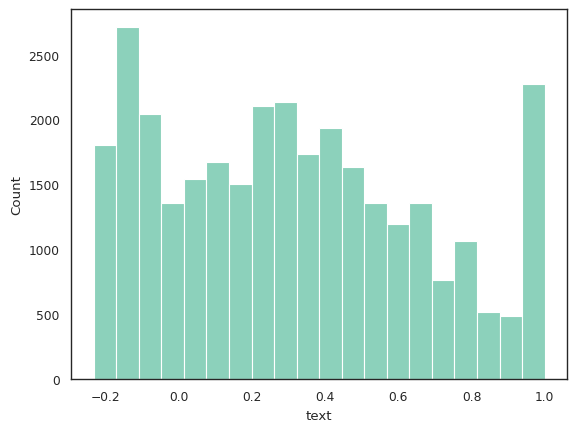

In [ ]:
print("The average MTLD is: ", text_to_mtld.mean())
print("The median MTLD is: ", text_to_mtld.median())
print("The 25% quantile of the MTLD is: ", text_to_mtld.quantile(0.25))
print("The 75% quantile of the MTLD is: ", text_to_mtld.quantile(0.75))
print("The maximum of the MTLD is: ", text_to_mtld.max())

normalized_mtld = text_to_mtld.apply(lambda x: x/60 - 15/60)
normalized_mtld = normalized_mtld.apply(lambda x: min(x, 1)) # 50 (75 percent quantile of our datas mtld) as 1, 0 as -0.15

sns.histplot(data=normalized_mtld, bins =20)


The average prosociality is:  0.01637942482518303
The median prosociality is:  -0.0034169554710388184
The 25% quantile of the prosociality is:  -0.02635766565799713
The 75% quantile of the prosociality is:  0.02757573127746582
The maximum of the prosociality is:  0.583224391937256
The minimum of the prosociality is:  -0.10151299834251404
Post_Id              106
CiviRank             106
CiviScore            106
Warning              106
Reddit_Score         106
Reddit_Score_Rank    106
text                 106
Score                106
Score_Rank           106
Timestamp            106
Parent_Id            106
Votes_Neg            106
Votes_Pos            106
id                   106
trustworthiness        3
no_toxicity          106
no_polarization      106
prosociality         106
mtld                 104
compound_score       106
dtype: int64


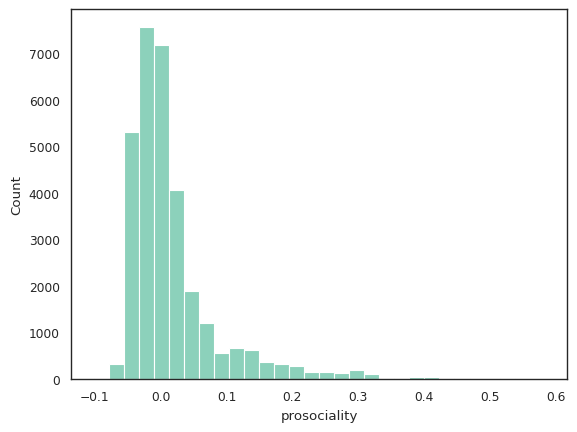



The average polarization is:  -0.048154532093726735
The median polarization is:  -0.03414040803909302
The 25% quantile of the polarization is:  -0.08001351356506348
The 75% quantile of the polarization is:  -0.001949310302734375
The maximum of the polarization is:  0.0767703652381897
The minimum of the polarization is:  -0.4948166608810425


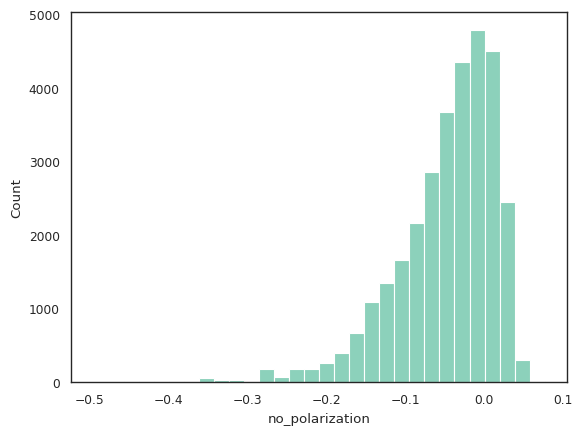

Post_Id              31276
CiviRank             31276
CiviScore            31276
Warning              31276
Reddit_Score         31276
Reddit_Score_Rank    31276
text                 31276
Score                31276
Score_Rank           31276
Timestamp            31276
Parent_Id            31276
Votes_Neg            31276
Votes_Pos            31276
id                   31276
trustworthiness        297
no_toxicity          31276
no_polarization      31276
prosociality         31276
mtld                 31234
compound_score       31276
dtype: int64


In [ ]:
print("The average prosociality is: ", complete['prosociality'].mean())
print("The median prosociality is: ", complete['prosociality'].median())
print("The 25% quantile of the prosociality is: ", complete['prosociality'].quantile(0.25))
print("The 75% quantile of the prosociality is: ", complete['prosociality'].quantile(0.75))
print("The maximum of the prosociality is: ", complete['prosociality'].max())
print("The minimum of the prosociality is: ", complete['prosociality'].min())
print(complete[complete['prosociality'] > 0.4].count())

sns.histplot(complete['prosociality'], bins=30)
plt.show()
print('\n')
print("The average polarization is: ", complete['no_polarization'].mean())
print("The median polarization is: ", complete['no_polarization'].median())
print("The 25% quantile of the polarization is: ", complete['no_polarization'].quantile(0.25))
print("The 75% quantile of the polarization is: ", complete['no_polarization'].quantile(0.75))
print("The maximum of the polarization is: ", complete['no_polarization'].max())
print("The minimum of the polarization is: ", complete['no_polarization'].min())
sns.histplot(complete['no_polarization'], bins=30)
plt.show()

print(complete[complete['no_polarization'] < 0.4].count())


The average prosociality is:  0.25603473461540266
The median prosociality is:  0.21248269796371463
The 25% quantile of the prosociality is:  0.16201313555240632
The 75% quantile of the prosociality is:  0.2806666088104248
The maximum of the prosociality is:  1.503093662261963
The minimum of the prosociality is:  -0.0033285963535308718


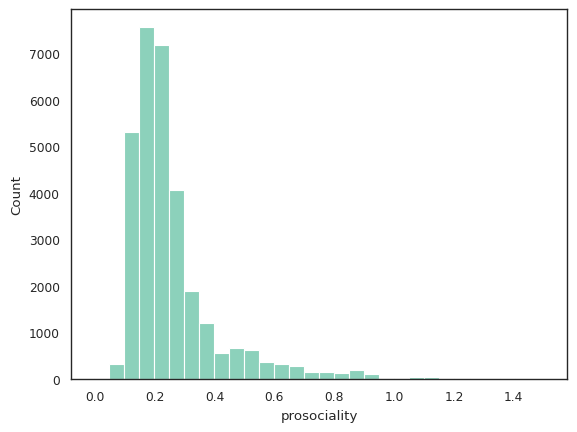



The average polarization is:  -0.3259399706061989
The median polarization is:  -0.2951088976860047
The 25% quantile of the polarization is:  -0.39602972984313967
The 75% quantile of the polarization is:  -0.22428848266601564
The maximum of the polarization is:  -0.05110519647598268
The minimum of the polarization is:  -1.3085966539382936


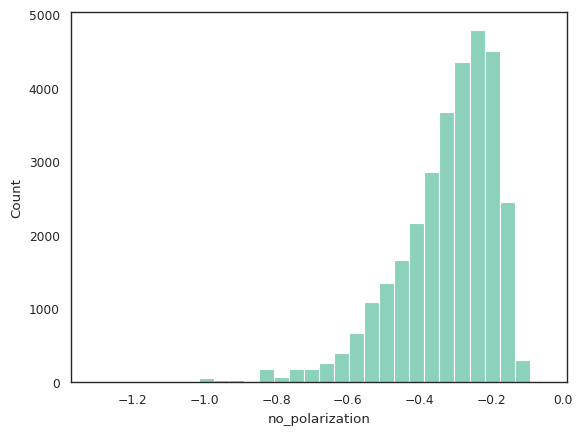

In [ ]:
def min_max(x, min, max, bottom_aim, top_aim):
  return ((x - min) * (top_aim - bottom_aim)) / (max - min)

scaled_pol = complete['no_polarization'].apply(lambda x: min_max(x, 0.1, -0.4, 0.1, -1))
scaled_prosoc = complete['prosociality'].apply(lambda x: min_max(x, -0.1, 0.4, -0.1, 1))
print("The average prosociality is: ", scaled_prosoc.mean())
print("The median prosociality is: ", scaled_prosoc.median())
print("The 25% quantile of the prosociality is: ", scaled_prosoc.quantile(0.25))
print("The 75% quantile of the prosociality is: ", scaled_prosoc.quantile(0.75))
print("The maximum of the prosociality is: ", scaled_prosoc.max())
print("The minimum of the prosociality is: ", scaled_prosoc.min())

sns.histplot(scaled_prosoc, bins=30)
plt.show()
print('\n')
print("The average polarization is: ", scaled_pol.mean())
print("The median polarization is: ", scaled_pol.median())
print("The 25% quantile of the polarization is: ", scaled_pol.quantile(0.25))
print("The 75% quantile of the polarization is: ", scaled_pol.quantile(0.75))
print("The maximum of the polarization is: ", scaled_pol.max())
print("The minimum of the polarization is: ", scaled_pol.min())
sns.histplot(scaled_pol, bins=30)
plt.show()



The average prosociality is:  0.052283269717330806
The median prosociality is:  -0.011389851570129395
The 25% quantile of the prosociality is:  -0.0878588855266571
The 75% quantile of the prosociality is:  0.0919191042582194
The maximum of the prosociality is:  1.0
The minimum of the prosociality is:  -0.3383766611417135


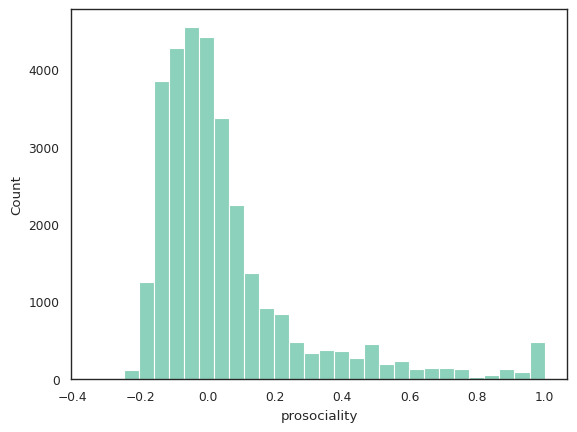



The average polarization is:  -0.15953750706554484
The median polarization is:  -0.11380136013031006
The 25% quantile of the polarization is:  -0.2667117118835449
The 75% quantile of the polarization is:  -0.006497701009114584
The maximum of the polarization is:  0.2559012174606323
The minimum of the polarization is:  -1.0


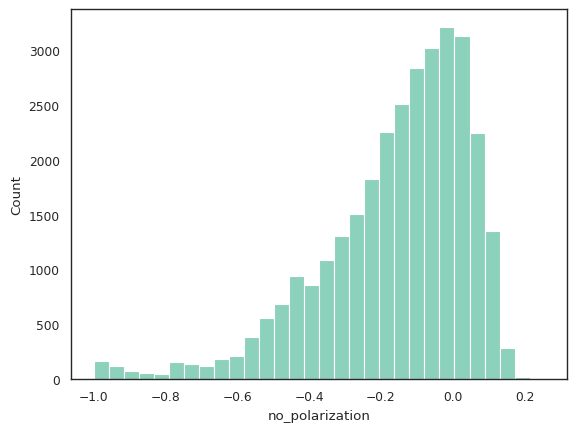

In [35]:
def min_max(x, min, max, bottom_aim, top_aim):
  return ((x - min) * (top_aim - bottom_aim)) / (max - min)

scaled_pol = complete['no_polarization'].apply(lambda x: min_max(x, 0, -0.3, 0, -1))
scaled_prosoc = complete['prosociality'].apply(lambda x: min_max(x, 0, 0.3, 0, 1))
scaled_pol = scaled_pol.apply(lambda x: 1 if x > 1 else x)
scaled_pol = scaled_pol.apply(lambda x: -1 if x < -1 else x)
scaled_prosoc = scaled_prosoc.apply(lambda x: 1 if x > 1 else x)
scaled_prosoc= scaled_prosoc.apply(lambda x: -1 if x < -1 else x)
print("The average prosociality is: ", scaled_prosoc.mean())
print("The median prosociality is: ", scaled_prosoc.median())
print("The 25% quantile of the prosociality is: ", scaled_prosoc.quantile(0.25))
print("The 75% quantile of the prosociality is: ", scaled_prosoc.quantile(0.75))
print("The maximum of the prosociality is: ", scaled_prosoc.max())
print("The minimum of the prosociality is: ", scaled_prosoc.min())

sns.histplot(scaled_prosoc, bins=30)
plt.show()
print('\n')
print("The average polarization is: ", scaled_pol.mean())
print("The median polarization is: ", scaled_pol.median())
print("The 25% quantile of the polarization is: ", scaled_pol.quantile(0.25))
print("The 75% quantile of the polarization is: ", scaled_pol.quantile(0.75))
print("The maximum of the polarization is: ", scaled_pol.max())
print("The minimum of the polarization is: ", scaled_pol.min())
sns.histplot(scaled_pol, bins=30)
plt.show()


In [36]:
weights = {
    "no_toxicity": 1,
    "no_polarization": 1,
    "mtld": 0.25,
    "trustworthiness": 2,
    "prosociality": 1
}

def calculate_compound_score(row, weights, debug=False):
    norm = 0
    compound_score = 0
    for score in weights.keys():
        if row[score] == row[score]: # nan-check
            compound_score += row[score] * weights[score]
            norm += weights[score]
    if norm != 0:
        return compound_score / norm
    else:
        return np.nan


scaled_df = pd.DataFrame({
    "trustworthiness": complete["trustworthiness"],
    "no_toxicity": complete["no_toxicity"],
    "no_polarization": scaled_pol,
    "prosociality": scaled_prosoc,
    "mtld": normalized_mtld,
})

# Calculate compound_score for each row in scaled_df
scaled_df["compound_score"] = scaled_df.apply(calculate_compound_score, args=(weights, False), axis=1)

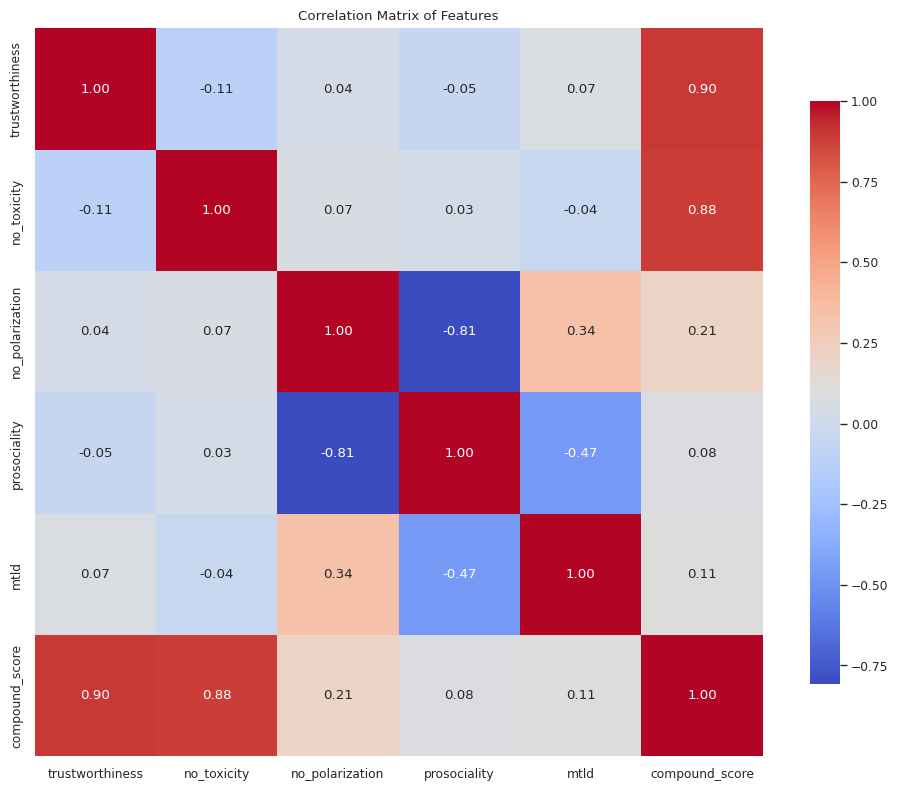

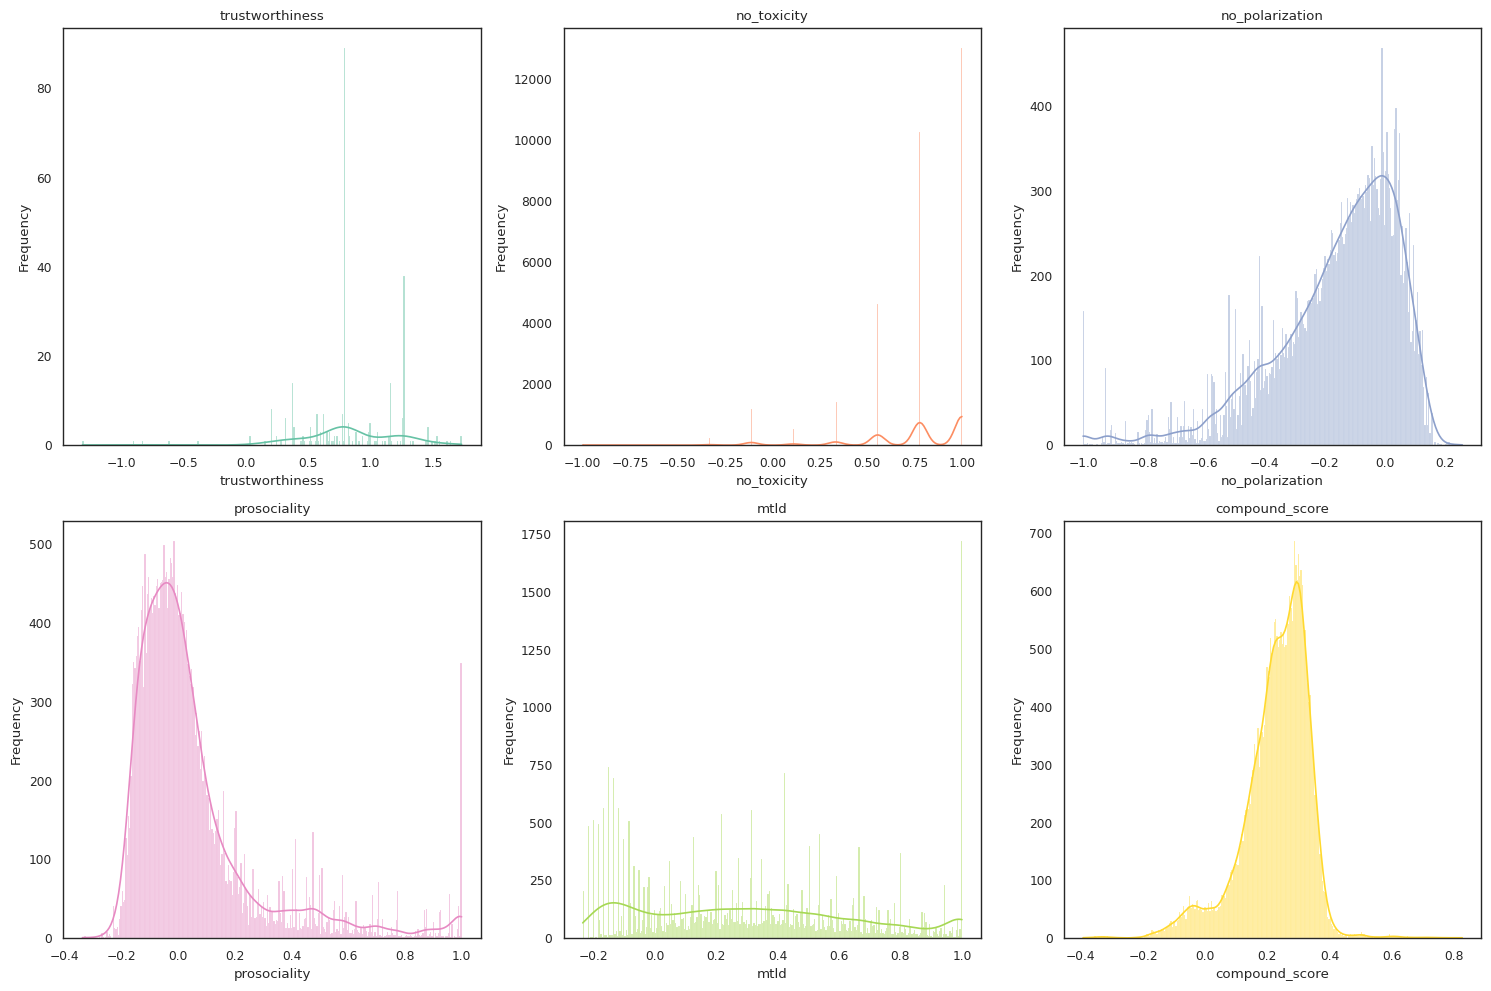

In [37]:
#for all rows in subser, show histogram and correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "correlation_matrix", plt)
# Plot the distribution of each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(scaled_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(scaled_df[column], bins=300, kde=True, color=custom_palette[i])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "feature_distribution", plt)

In [ ]:
subset = complete[["compound_score","trustworthiness", "no_toxicity", "no_polarization", "prosociality", "mtld"]].copy()
subset["mtld"] = subset["mtld"] *0.5

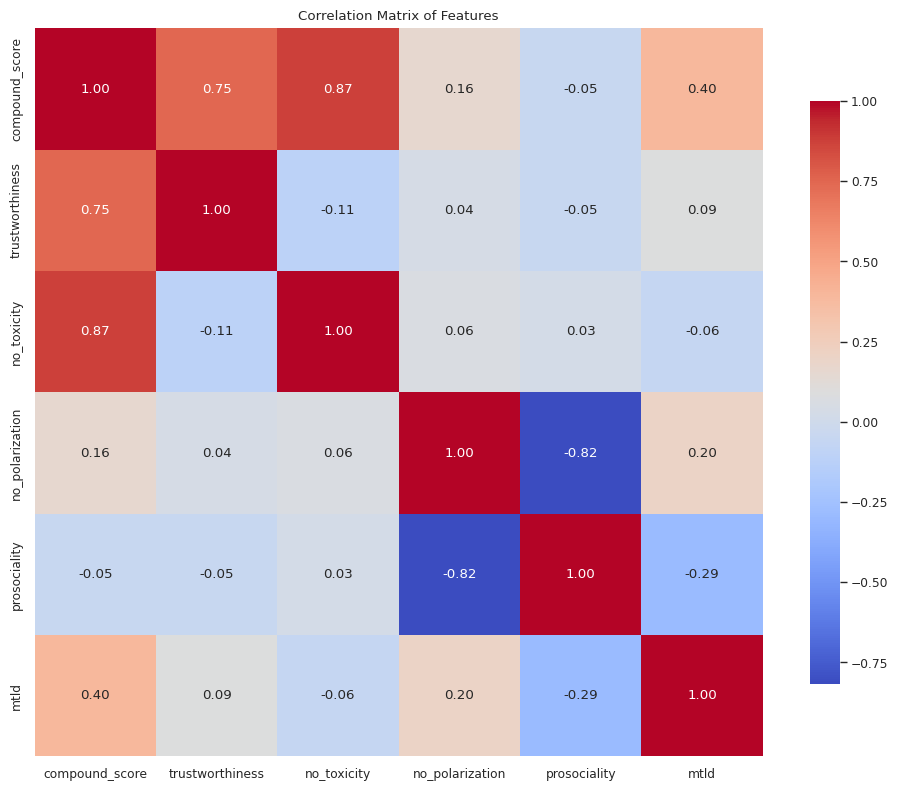

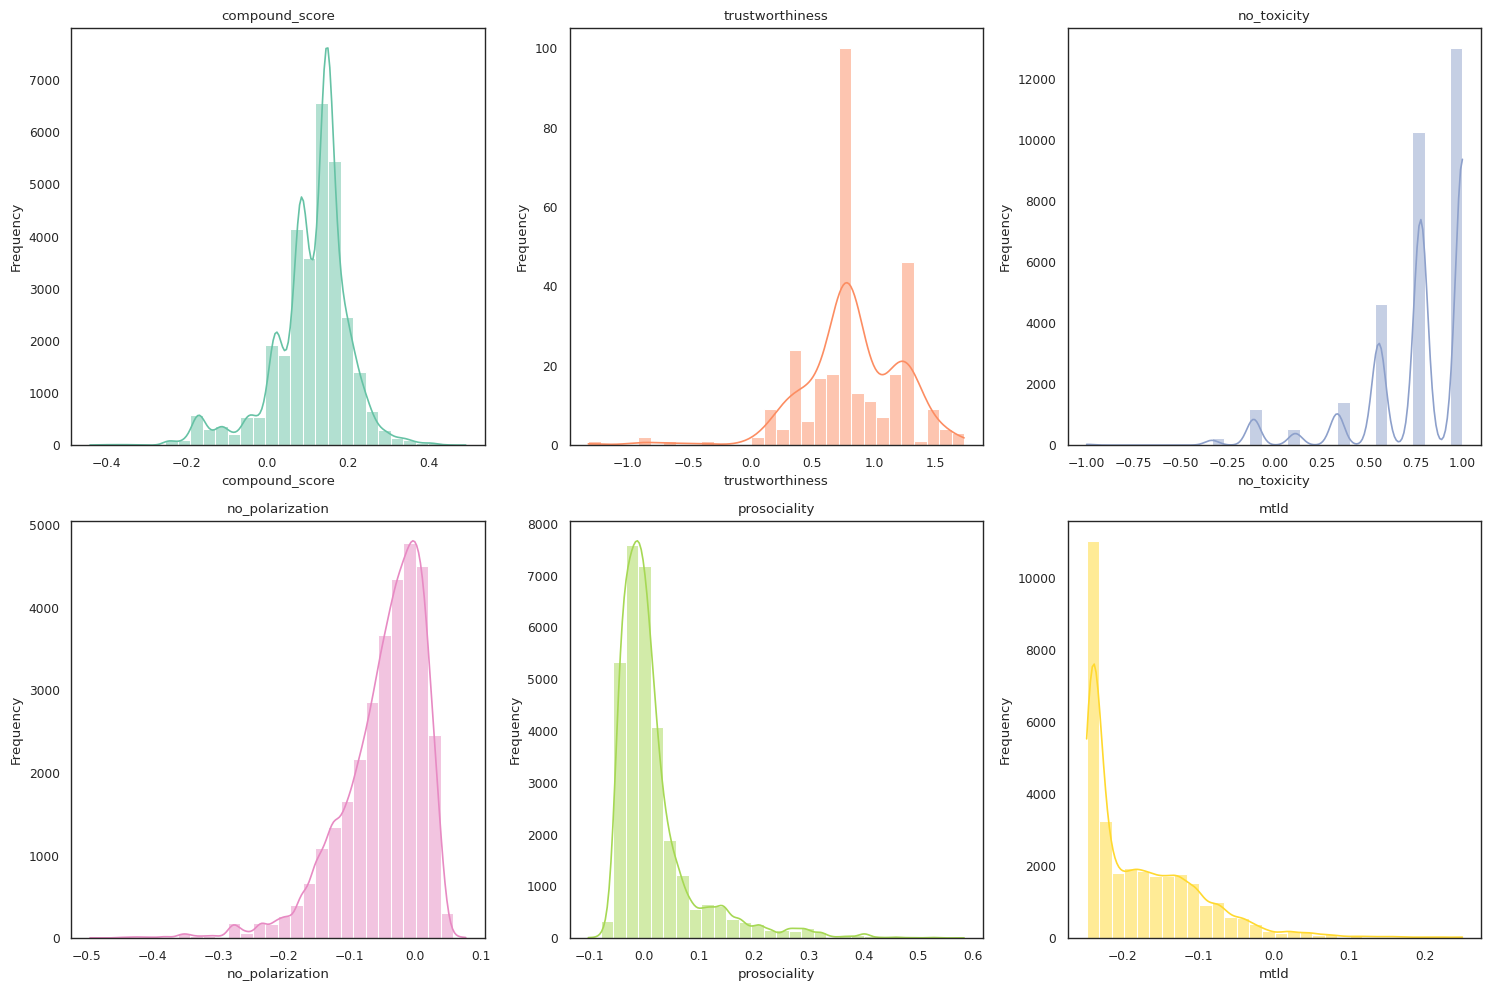

In [ ]:
#for all rows in subser, show histogram and correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(subset.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix of Features")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "correlation_matrix", plt)
# Plot the distribution of each feature
plt.figure(figsize=(15, 10))
for i, column in enumerate(subset.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(subset[column], bins=30, kde=True, color=custom_palette[i])
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()
#utils.plot(PRINT_PLOTS, "feature_distribution", plt)